# Assignment 2

In this assignment, you will develop a deep learning model capable of classifying real brain signals into different types of motion. The first sections are meant to get you comfortable with the type of data. Instructions for the assigment are found in the last section of this notebook.

---
## Data and task description

The data you will be using comes from an open-source library of human electrocorticographic (ECoG) data published in 2019 by Dr. Kai Miller at Stanford University ([link to publication](https://www.nature.com/articles/s41562-019-0678-3)). ECoG involves recording electrical brain activity directly from the cerebral cortex via electrode grids placed on the surface of the brain, underneath the skull. This involves an invasive procedure, which is why ECoG data is typically obtained from patients who must undergo a craniotomy for clinical reasons. Some of the benefits of ECoG over non-invasive recording methods like electroencephalography (EEG) include better spatial resolution and a better signal-to-noise ratio.

The data in question was recorded from 7 subjects under the following experimental task. Following presentation of a visual stimulus, the subject had to perform repetitive hand or tongue motion (clenching and releasing a fist or sticking the tongue in and out, both at a self-paced rate of 1-2Hz). Stimuli were always presented for 3 seconds each, and were followed by a few seconds of rest before the next stimulus. For hand motion, the movement was always contralateral to the side of electrode placement.

### Task:
Your task for this assignment is to build a convolutional neural network (CNN) capable of performing the binary classification task of determining whether an input ECoG signal happened during tongue or hand motion.

### Technical dataset details:
- Electrode grid size: variable across patients
- Electrode grid placement: frontal lobe
- Sampling rate: 1000Hz
- Number of stimuli per patient: 60
    - Tongue motion stimuli: 30
    - Hand motion stimuli: 30

### Preprocessing:
For simplicity, the data has already been preprocessed for you. This is a summary of the preprocessing steps taken:
1. Notch filter at 60, 120, 180, 240, and 250Hz to remove [electric hum](https://en.wikipedia.org/wiki/Mains_hum)
2. Baseline normalization to reduce cross-subject variability
3. For each subject, keep only signals from electrodes placed over motor and premotor cortex (i.e., Brodmann areas 4 and 6, respectively)
4. High-pass filter signals at 1Hz to remove low-frequency drift
5. Low-pass filter signals at 200Hz to reduce high-frequency noise
6. Segment signals and keep only epochs representing stimulus presentation
    - Each resulting epoch is 3 seconds long
7. Perform z-score normalization over time for each epoch
8. Treat each epoch as a separate sample, then concatenate them into a single matrix
    - Resulting dimensions: 5040 (n_epochs) X 600 (n_time_samples: 3 seconds * 200Hz)
9. Downsample each epoch to 200Hz for lighter downstream computations
10. Label each epoch according to its associated stimulus (0 = tongue motion, 1 = hand motion)
11. Perform a training : validation : test split of 0.70 : 0.15 : 0.15. This split was stratified to preserve the ratio of hand and tongue samples across splits
10. Store split data as a compressed array under `assignment_2/data/preproc_data.npz`

---
## Data exploration

Here are a few examples of how you can manipulate the data provided under `data/ecog_data.npz`

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# load the data
fname = 'data/ecog_data.npz'
data = np.load(fname)

# for training
X_train = data['X_train'] # ECoG
y_train = data['y_train'] # labels
print(f'Training samples: {X_train.shape[0]}')

# for tuning
X_val = data['X_val']
y_val = data['y_val']
print(f'Validation samples: {X_val.shape[0]}')

# for final evaluation
X_test = data['X_test']
y_test = data['y_test']
print(f'Test samples: {X_test.shape[0]}')

Training samples: 3528
Validation samples: 756
Test samples: 756


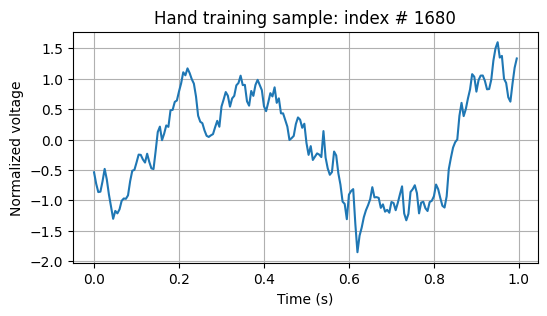

In [5]:
# visualize 1 second of a random sample

srate = 200 #Hz
time = np.arange(0, 1, 1 / srate)

idx = np.random.randint(0, len(X_train))
sample = X_train[idx, :len(time)]
label = y_train[idx]
label = 'Tongue' if label == 0 else 'Hand'

fig, ax = plt.subplots(1, 1, figsize=[6, 3])
ax.plot(time, sample)
ax.grid(True)
ax.set_ylabel('Normalized voltage')
ax.set_xlabel('Time (s)')
ax.set_title(f'{label} training sample: index # {idx}');


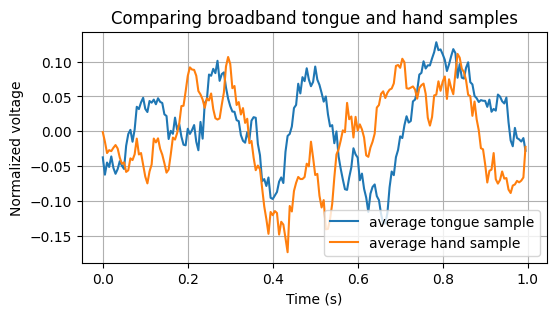

In [6]:
# comparing hand vs tongue trials

tongue_idx = np.where(y_train == 0)[0]
hand_idx = np.where(y_train == 1)[0]

mean_tongue = X_train[tongue_idx, :len(time)].mean(0)
mean_hand = X_train[hand_idx, :len(time)].mean(0)

fig, ax = plt.subplots(1, 1, figsize=[6, 3])
ax.plot(time, mean_tongue)
ax.plot(time, mean_hand)
ax.legend(['average tongue sample', 'average hand sample'])
ax.grid(True)
ax.set_ylabel('Normalized voltage')
ax.set_xlabel('Time (s)')
ax.set_title(f'Comparing broadband tongue and hand samples');

As you can see, it might difficult to determine the presence of a differentiating signal from these average traces alone. For this reason, typical analyses of ECoG data involve the use of **frequency filters**. 

Frequency filters in ECoG analyses isolate neural activity relevant to cognitive processes, enhancing signal clarity by reducing noise and isolating specific frequency bands associated with tasks like motor control. Filtering aids in removing artifacts and unwanted physiological noise, improving the signal-to-noise ratio for detecting meaningful neural correlates. By focusing on targeted frequency ranges, researchers extract valuable insights into brain function and cognition.

Below, we use a bandpass filter to isolate the beta band (13-30Hz) of hand and tongue samples, since this frequency band is known to be associated with motor control and movement suppression.

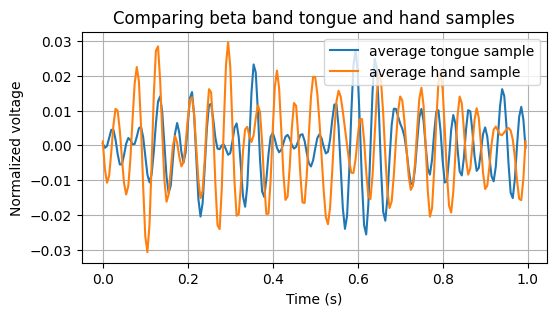

In [7]:
# beta band filter

b, a = signal.butter(3, [13, 30], btype='bandpass', fs=200)
beta_tongue = signal.filtfilt(b, a, mean_tongue)
beta_hand = signal.filtfilt(b, a, mean_hand)

fig, ax = plt.subplots(1, 1, figsize=[6, 3])
ax.plot(time, beta_tongue)
ax.plot(time, beta_hand)
ax.legend(['average tongue sample', 'average hand sample'])
ax.grid(True)
ax.set_ylabel('Normalized voltage')
ax.set_xlabel('Time (s)')
ax.set_title(f'Comparing beta band tongue and hand samples');

While both signals remain rather difficult to distinguish, you can begin to appreciate how filtering plays a crucial role in isolating specific frequency components of signals, enhancing their interpretability and enabling the extraction of meaningful features.

 Similarly, CNNs leverage convolution operations to automatically learn and extract hierarchical features from raw input data. This process is particularly effective for extracting distinguishing patterns or features from complex time series signals like ECoG data. By applying convolutional filters, CNNs can capture local patterns in the data, allowing them to identify and distinguish relevant features associated with behaviours like hand or tongue movement. The added benefit of employing CNNs is the fact that none of the filters have to be designed by the data analyst; their parameters are all learned by the network instead!

---
## Assignment Instructions

Using the provided ECoG data and associated labels, develop, train and evaluate a binary classifier capable of differentiating tongue and hand motion signals. To this end, create the following scripts:

1. `dataloader.py`
- This script should contain any methods or classes needed to load and prepare your ECoG data for use by a downstream CNN
    - While the data has already been preprocessed for you, feel free to implement any additional preprocessing steps in your dataloader

2. `model.py`
- In this script, define your 1D CNN architecture
- **Required**:
    - This network must return prediction probabilities for each input sample
- **Recommended architecture**:
    - Stem layer:
        - conv1: in_channels=1, out_channels=32, kernel_size=8, stride=8, padding=0
        - conv2: in_channels=32, out_channels=64, kernel_size=8, stride=8, padding=0
        - ReLU

    - Feature extractor:
        - conv1: in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        - batch normalization
        - ReLU
        - maxpool1: kernel_size=2, stride=2
        - dropout1: p=0.4
        - conv2: in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        - batch normalization
        - ReLU
        - maxpool2: kernel_size=2, stride=2
        - dropout2: p=0.4

        - Global pooling: average over last dimension to obtain feature vector with size (256, 1)
        - dropout3: p=0.4

    - Prediction head:
        - Fully connected linear layer: in_channels=256, out_channels=1
        - Sigmoid

3. `train_and_eval.py`
- This script implements your training algorithm as well as your evaluation strategy. It should enable you to:
    - Train the model defined in model.py using the training data from dataloader.py via a training algorithm with variable hyperparameters such as learning rate, batch size, # of epochs, etc.
    - Evaluate a trained model on a held out set (validation or test)
    - Calculate and store relevant evaluation metrics to monitor model performance

- **Required:** your evaluation function must return an AUROC score, since this will be the metric used to evaluate model performance

4. `pipeline.py`
- This script wraps all previous scripts to enable a quick way to run learning experiments
- **Required:** 
    - Your script must read a JSON or YAML configuration file specifying all variable settings across the different steps in the pipeline
        - Think batch size, learning rate, # of epochs, patience for early stopping, etc.
    - Your script must also print out the final performance of your model on the test set at the end of the pipeline
- **Recommended:** 
    - **Optimizer choice:** For such simple CNNs, it is recommended to use SGD with momentum as your optimizer of choice
    - **Loss function**: For this binary classification task, we recommend you use binary cross entropy as your criterion
    - This script should also save figures and/or tables that allow you to examine the learning behaviour and validation performance of your model under various configurations
        - These will inform your hyperparameter tuning process
    

### Deliverables

You will find a subdirectory named `blueprint` in the directory for this assignment. As the name suggests, this contains a blueprint for each of your deliverables. You must **submit a single compressed file with the exact same structure as the `blueprint` directory**. In other words, along with the 4 scripts described above, your submission should also contain the following:
- `__init__.py`: an init file. You may leave it empty.
- `utils.py`: a file containing a helper function to read YAML or JSON files. You may add more helper functions to this script, though no modifications are necessary.
- `config.yaml`: this is an example configuration file that needs to be modified depending on your implementation of the DL pipeline. You can add and subtract as many configurations as you want from this file. The final version submitted should contain optimal configurations under which you obtained your best model performance on the test set, as measured by the AUROC score.

### Evaluation

Using the provided data, recommended CNN architecture, and configurations file, we ran 20 learning experiments to obtain a distribution of test set performance for this basic pipeline. The result was an `AUROC score = 0.8114 ± 0.0671`.

We will evaluate your submission by running the following command from the command line:

`python pipeline.py <config_file>`

You will pass the assignment if:
1. Your pipeline runs with no errors
2. Over 20 different evaluations, the average test set AUROC score is > 0.74. This is equal to the average performance of our experiments minus 1 standard deviation.



